In [ ]:
import tensorflow as tf


In [ ]:
SENTENCES = ["machine learning engineers can build great data models",
             "machine learning is a great new tool",
             "machine learning gives value to your data",
             "machine learning and data is all you need"
            ]

In [ ]:
from collections import Counter
import json
import numpy as np
class Vocabulary:
    
    def __init__(self, vocabulary, wordFrequencyFilePath):
        self.vocabulary = vocabulary
        self.BAG_OF_WORDS_FILE_FULL_PATH = wordFrequencyFilePath
        self.input_word_index = {}
        self.reverse_input_word_index = {}
        
        self.input_word_index["START"] = 1
        self.input_word_index["UNKOWN"] = -1
        self.MaxSentenceLength = None
        
    def PrepareVocabulary(self,reviews):
        self._prepare_Bag_of_Words_File(reviews)
        self._create_Vocab_Indexes()
        
        self.MaxSentenceLength = max([len(txt.split(" ")) for txt in reviews])
      
    def Get_Top_Words(self, number_words = None):
        if number_words == None:
            number_words = self.vocabulary
        
        chars = json.loads(open(self.BAG_OF_WORDS_FILE_FULL_PATH).read())
        counter = Counter(chars)
        most_popular_words = {key for key, _value in counter.most_common(number_words)}
        return most_popular_words
    
    def _prepare_Bag_of_Words_File(self,reviews):
        counter = Counter()    
        for s in reviews:
            counter.update(s.split(" "))
            
        with open(self.BAG_OF_WORDS_FILE_FULL_PATH, 'w') as output_file:
            output_file.write(json.dumps(counter))
                 
    def _create_Vocab_Indexes(self):
        INPUT_WORDS = self.Get_Top_Words(self.vocabulary)

        #word to int
        #self.input_word_index = dict(
        #    [(word, i) for i, word in enumerate(INPUT_WORDS)])
        for i, word in enumerate(INPUT_WORDS):
            self.input_word_index[word] = i
        
        #int to word
        #self.reverse_input_word_index = dict(
        #    (i, word) for word, i in self.input_word_index.items())
        for word, i in self.input_word_index.items():
            self.reverse_input_word_index[i] = word

        #self.input_word_index = input_word_index
        #self.reverse_input_word_index = reverse_input_word_index
        #seralize.dump(config.DATA_FOLDER_PATH+"input_word_index.p",input_word_index)
        #seralize.dump(config.DATA_FOLDER_PATH+"reverse_input_word_index.p",reverse_input_word_index)
        
        
    def _word_to_One_Hot_Vector(self, word):
        vector = np.zeros(self.vocabulary)
        vector[vocab.input_word_index[word]] = 1
        return vector
        
    def TransformSentencesToId(self, sentences):
        vectors = []
        for r in sentences:
            words = r.split(" ")
            vector = np.zeros(len(words))

            for t, word in enumerate(words):
                if word in self.input_word_index:
                    vector[t] = self.input_word_index[word]
                else:
                    pass
                    #vector[t] = 2 #unk
            vectors.append(vector)
            
        return vectors
    
    def ReverseTransformSentencesToId(self, sentences):
        vectors = []
        for r in sentences:
            words = r.split(" ")
            vector = np.zeros(len(words))

            for t, word in enumerate(words):
                if word in self.input_word_index:
                    vector[t] = self.input_word_index[word]
                else:
                    pass
                    #vector[t] = 2 #unk
            vectors.append(vector)
            
        return vectors
    
    
    def Get_SkipGram_Target_Words(self, sentences, WINDOW_SIZE = 5):
        SKIP_GRAM_INPUT_WORD_LIST = []
        
        for sentence in sentences:
            sentence_tokenized = sentence.split(" ")
            
            for index, target_word in enumerate(sentence_tokenized):
                FROM_INDEX = max(index-WINDOW_SIZE,0)
                TO_INDEX = min(index+1+WINDOW_SIZE,len(sentence_tokenized))

                for contextWord in sentence_tokenized[FROM_INDEX:TO_INDEX]:
                    if contextWord != target_word:
                        SKIP_GRAM_INPUT_WORD_LIST.append((target_word,contextWord))
                    
        return SKIP_GRAM_INPUT_WORD_LIST
    
    
    def Get_SkipGram_Target_Words_OneHotEncoded_XY(self, sentences, WINDOW_SIZE = 5):
        Skip_Gram_Target_Words = self.Get_SkipGram_Target_Words(sentences, WINDOW_SIZE)
        
        X,Y = [],[]
        
        for target_word, context_word in Skip_Gram_Target_Words:
            X.append(self._word_to_One_Hot_Vector(target_word))
            Y.append(self._word_to_One_Hot_Vector(context_word))
            
        return np.asarray(X), np.asarray(Y)

In [ ]:
VOCABULARY_SIZE = 20
vocab = Vocabulary(VOCABULARY_SIZE,"words.vocab")
vocab.PrepareVocabulary(SENTENCES)
vocab.Get_Top_Words(5)
print("Vocabulary of {0} words".format(len(vocab.Get_Top_Words())))

In [ ]:
SENTENCES[0]

In [ ]:
Skip_Gram_Target_Words = vocab.Get_SkipGram_Target_Words(SENTENCES, WINDOW_SIZE=2)
print(Skip_Gram_Target_Words[0:5])

In [ ]:
X_train, Y_train = vocab.Get_SkipGram_Target_Words_OneHotEncoded_XY(SENTENCES,2)

In [8]:
print(X_train.shape)
print(Y_train.shape)

In [9]:
VOCABULARY_SIZE

In [14]:
EMBEDDING_DIM = 5

# Inputs
X = tf.placeholder("float", shape=[None, VOCABULARY_SIZE])
y = tf.placeholder("float", shape=[None, VOCABULARY_SIZE])

# Dictionary of Weights and Biases
weights = {
  'W1': tf.Variable(tf.random_normal([VOCABULARY_SIZE, EMBEDDING_DIM])),
  'W2': tf.Variable(tf.random_normal([EMBEDDING_DIM, VOCABULARY_SIZE])),
}

biases = {
  'b1': tf.Variable(tf.random_normal([EMBEDDING_DIM])),
  'b2': tf.Variable(tf.random_normal([VOCABULARY_SIZE])),
}


# Model Forward Propagation step
def forward_propagation(x):
    hidden_1 = tf.add(tf.matmul(x, weights['W1']), biases['b1'])   
    out_layer = tf.add(tf.matmul(hidden_1, weights['W2']), biases['b2'])
    
    softmax_out = tf.nn.softmax(out_layer)    
    return softmax_out

#cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=yhat))
#optimizer = tf.train.GradientDescentOptimizer(learning_rate)

yhat = forward_propagation(X)
ypredict = tf.argmax(yhat, axis=1)

# Backward propagation
learning_rate = 0.02
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=yhat))
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train_op = optimizer.minimize(cost)

In [15]:
# Initializing the variables
init = tf.global_variables_initializer()

from datetime import datetime
startTime = datetime.now()

sess = tf.Session()
#with tf.Session() as sess:
sess.run(init)

#writer.add_graph(sess.graph)
#EPOCHS
for epoch in range(500):
    #Stochasting Gradient Descent
    for i in range(len(X_train)):
        #cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(y * tf.log(yhat), reduction_indices=[1]))
        summary = sess.run(train_op, feed_dict={X: X_train[i: i + 1], y: Y_train[i: i + 1]})

    if epoch % 50 == 0:
        train_accuracy = np.mean(np.argmax(Y_train, axis=1) == sess.run(ypredict, feed_dict={X: X_train, y: Y_train}))
        current_cost_ = sess.run(cost, feed_dict={X: X_train, y: Y_train})
        #cross_entropy_loss_val = sess.run(cross_entropy_loss, feed_dict={X: X_train, y: Y_train})

        print("Epoch = {0}, train accuracy = {1}%, cost = {2}".format(epoch + 1, 100. * train_accuracy,current_cost_))
        
        #print("Epoch = %d, train accuracy = %.2f%%, train accuracy = %.2f%%" % (epoch + 1, 100. * train_accuracy, cross_entropy_loss_val))

    #sess.close()
print("Time taken:", datetime.now() - startTime)



#sess.close()

Epoch = 1, train accuracy = 7.291666666666667%, cost = 2.991915464401245
Epoch = 51, train accuracy = 16.666666666666664%, cost = 2.9074742794036865
Epoch = 101, train accuracy = 18.75%, cost = 2.89859938621521
Epoch = 151, train accuracy = 18.75%, cost = 2.8892109394073486
Epoch = 201, train accuracy = 19.791666666666664%, cost = 2.8809940814971924
Epoch = 251, train accuracy = 20.833333333333336%, cost = 2.8676044940948486
Epoch = 301, train accuracy = 20.833333333333336%, cost = 2.8654215335845947
Epoch = 351, train accuracy = 20.833333333333336%, cost = 2.8641796112060547
Epoch = 401, train accuracy = 21.875%, cost = 2.8569447994232178
Epoch = 451, train accuracy = 21.875%, cost = 2.8540782928466797
Time taken: 0:00:12.197000


In [16]:
ypredict= sess.run(ypredict, feed_dict={X: X_train, y: Y_train})

ypredict.shape

(96,)

In [17]:
vectors = sess.run(weights['W1'] + biases['b1'])
vectors.shape

(20, 5)

In [18]:
print(vectors[vocab.input_word_index['machine']])
print(vectors[vocab.input_word_index['learning']])

[-0.21159199 -1.80345058  1.78221071 -1.50964272  2.91589117]
[-1.05467892  0.72682083  0.27032721 -0.59880066  2.81437683]


<h2>Plot Embedding</h2>

In [19]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

X = []
for word in vocab.Get_Top_Words():
    X.append(vectors[vocab.input_word_index[word]])
X = np.asarray(X)

print(X.shape)

(20, 5)


In [20]:
pca = PCA(n_components=2)
result = pca.fit_transform(X)

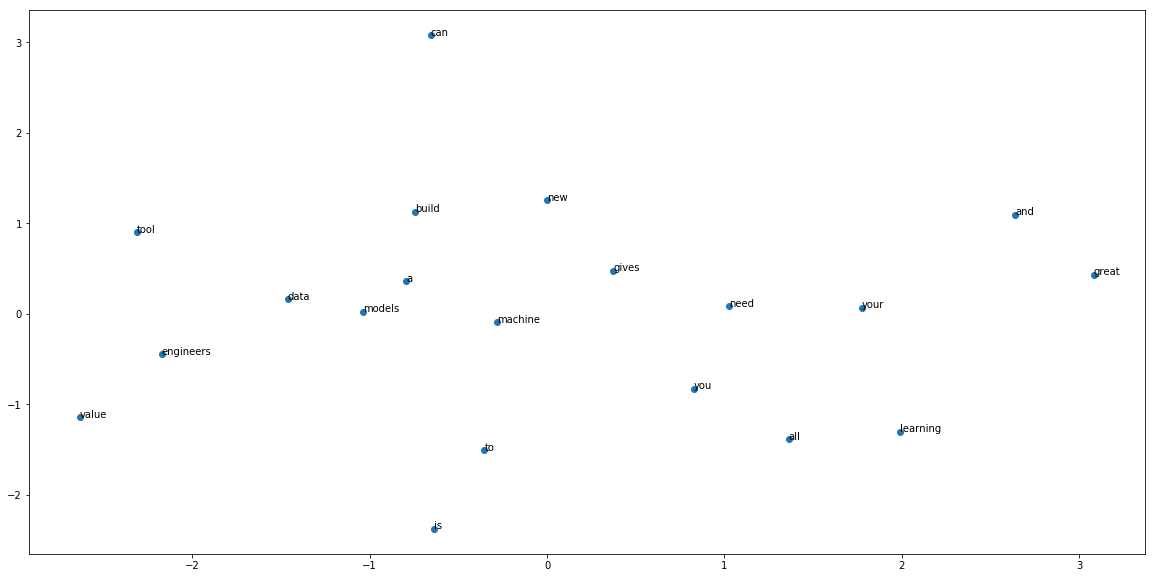

In [21]:
# create a scatter plot of the projection
plt.figure(figsize=(20,10))
plt.scatter(result[:, 0], result[:, 1])
words = vocab.Get_Top_Words()
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [22]:
sess.close()